Globally averaged temperature:

$$
\frac{dT}{dt} = R_i(T) -  R_0(T, C)
$$

Accumulated anthropogenic carbon, $S_a$
$$
\frac{d S_a}{dt} = C_a
$$

Atmospheric carbon concentration:

$$
\frac{dC}{dt} = v + C_a - W_a A_v C g^{vege}(T) + \frac{c_0}{\tau_c} \kappa_P (1 - f(T)) + \frac{c_0}{\tau_c} \kappa_B(S_a) (1 - f(T)) - \frac{\lambda}{\tau_c} C(1 - f(T))
$$

Temperature anomaly:
$$
\tilde{T} = T - T_{preindustrial}
$$



$$
\begin{align}
\delta \phi(\tilde{T}, C, S_a) =& \max_{C_a} \eta \delta \log C_a  \\
& + \frac{d \phi (\tilde{T}, C, S_a)}{d\tilde{T}} \left( R_i(T) - R_0(T, C) \right)\\
& + \frac{d\phi(\tilde{T}, C, S_a)}{d C} \left( v + C_a - W_a A_v C g^{vege}(T) + \frac{c_0}{\tau_c} \kappa_P (1 - f(T)) + \frac{c_0}{\tau_c} \kappa_B(S_a) (1 - f(T)) - \frac{\lambda}{\tau_c} C(1 - f(T))\right)\\
& + \frac{d \phi (\tilde{T}, C, S_a)}{d S_a} C_a \\
& + (\eta - 1) (\gamma_1 + \gamma_2 \tilde{T}) (R_i(T) - R_0(T, C))
\end{align}
$$

$$
C_a^{*} = - \frac{\delta \eta}{\frac{d \phi (\tilde{T}, C, S_a)}{d C} + \frac{d \phi (\tilde{T}, C, S_a)}{d S_a} }
$$

In [1]:
import sys
sys.path.append("../src/")
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import SymLogNorm
import matplotlib.mlab
import scipy.io as sio
import pandas as pd
import scipy.optimize as optim
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy import fft, arange, signal
from scipy.interpolate import RegularGridInterpolator
import SolveLinSys
from supportfunctions import finiteDiff
rcParams["figure.figsize"] = (8,5)
                                                                                
def PDESolver(stateSpace, A, B1, B2, B3, C1, C2, C3, D, v0, 
              ε = 1, tol = -10):                                              
                                                                                 

    A = A.reshape(-1,1,order = 'F')                                         
    B = np.hstack([B1.reshape(-1,1,order = 'F'),B2.reshape(-1,1,order = 'F'),B3.reshape(-1,1,order='F')])
    C = np.hstack([C1.reshape(-1,1,order = 'F'),C2.reshape(-1,1,order = 'F'),C3.reshape(-1,1,order='F')])
    D = D.reshape(-1,1,order = 'F')                                         
    v0 = v0.reshape(-1,1,order = 'F')                                       
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)           

    return out                                                            

In [2]:
# Pre-industrial: 282.87K

sa = 1
# Incoming radiation
Q0 = 342.5
## land fraction and albedo
#Fraction of land on the planet
p = 0.3

## outgoing radiation linearized
kappa  = 1.74
Tkappa = - 119.15
# Greenhouse effect parameter
B = 5.35 # a in the notes, CO2 radiative forcing

## Volcanism emissions
Volcan = 0.05964

Ts =   9.72
Cs = 587.40 # Average carbon with no Ca

alphaland = 0.28
bP = 0.05
bB = 0.08
cod = 3.035 # λ in the notes, Oceanic pump modulation parameter
cearth = 0.107 # heat capacity
tauc = 20
coc0 =  745.5 # initial oceanic carbon stock
## Ocean albedo parameters, in celsius
Talphaocean_low  = - 54.15
Talphaocean_high = 25.85
alphaocean_min   = 0.255
alphaocean_max   = 0.84


Cbio_low  = 106.5 # Gt
Cbio_high = 1491 # Gt

T0 = 24.85
C0 = 596.5 # reference CO2 level, in Gt

## CO2 uptake by vegetation
wa       = 0.03195 # Gt/yr
vegcover = 0.4 # Av in notes

Thigh = 41.85
Tlow  =  8.85
Topt1 = 21.85
Topt2 = 36.85
acc   = 5


# Ocean albedo
def alphaocean(T):
    """T, matrix, (nT, nC, nF)"""
    temp = np.zeros(T.shape)
    temp[ T< Talphaocean_low ] = alphaocean_max
    temp[ (T>= Talphaocean_low)&(T< Talphaocean_high)] = alphaocean_max + (alphaocean_min - alphaocean_max) / (Talphaocean_high - Talphaocean_low) * (T[(T>= Talphaocean_low)&(T< Talphaocean_high)] - Talphaocean_low)
    temp[T>= Talphaocean_high] = alphaocean_min

    return temp
    
#Fraction of ocean covered by ice
def fracseaice(T):
    
    temp = np.zeros(T.shape)
    temp[ T< Talphaocean_low ] = 1
    temp[ (T>= Talphaocean_low)&(T< Talphaocean_high)] = 1 - 1 / (Talphaocean_high - Talphaocean_low) * (T[(T>= Talphaocean_low)&(T< Talphaocean_high)] - Talphaocean_low)
    temp[T>= Talphaocean_high] = 0

    return temp
    


def biopump(F):
    """F, accumulated anthrpogenic emission"""
    temp = np.zeros(F.shape)
    
    temp[F < Cbio_low] = 1
    temp[(F >= Cbio_low)&(F < Cbio_high)] = 1 - 1/(Cbio_high - Cbio_low) * (F[(F >= Cbio_low)&(F < Cbio_high)] - Cbio_low)
    temp[F >= Cbio_high] = 0
    return temp


def veggrowth(T):
    
    temp = np.zeros(T.shape)
    
    temp[T < Tlow] = 0
    temp[(T >= Tlow)&(T < Topt1)] = acc / (Topt1 - Tlow) * (T[(T >= Tlow)&(T < Topt1)] - Tlow)
    temp[(T >= Topt1)&(T < Topt2)] = acc
    temp[(T >= Topt2)&(T < Thigh)] = acc / (Topt2 - Thigh) * (T[(T >= Topt2)&(T < Thigh)] - Thigh)
    temp[T > Thigh] = 0
    
    return temp


#Incoming radiation modified by albedo
def Ri(T):
    return 1/cearth * (Q0 * (1 - p * alphaland - (1 - p) * alphaocean(T)))

# Outgoing radiation modified by greenhouse effect
def Ro(T, C):
    return 1/cearth * (kappa * (T - Tkappa) -  B * np.log(C / C0))

#Solubility of atmospheric carbon into the oceans
# carbon pumps
def kappaP(T):
    return np.exp(-bP * (T - T0))

def oceanatmphysflux(T):
    return 1 / tauc * (coc0 * (np.exp(-bP * (T - T0))))

def oceanbioflux(T, F, sa):
    
    if sa == 1:
        
        return 1/tauc * (coc0 * (np.exp(bB * biopump(F) * (T - T0))))
    
    elif sa == 0:
        
        return 1/tauc * (coc0 * (np.exp(bB * (T - T0))))
    
    else:
        return ValueError("Wrong input value: 0 or 1.")

def oceanatmcorrflux(C):
    return 1 / tauc * (- cod * C)

In [11]:
# Economic paramaters
gamma_1 = 1.7675 / 10000.
gamma_2 = 2 * 0.0022
delta   = 0.01
eta     = 0.032

# State variable
# Temperature anomaly, in celsius
T_min  = 0. 
T_max  = 20. # 
hT     = 0.2
T_grid = np.arange(T_min, T_max + hT, hT)

# atmospheric carbon concentration, in gigaton
C_min  = 532.5
C_max  = 1065
hC     = 10
C_grid = np.arange(C_min, C_max + hC, hC)

# F, Sa in the notes, accumulative anthropogenic carbon, in gigaton
F_min = 600. # 10. avaoid 
F_max = 5325. # 2500 x2.13 gm # # on hold -> 4000 / 2.13 ppm
hF = 50.
F_grid = np.arange(F_min, F_max + hF, hF)

# meshgrid
(T_mat, C_mat, F_mat) = np.meshgrid(T_grid, C_grid, F_grid, indexing="ij")
stateSpace = np.hstack([
    T_mat.reshape(-1, 1, order="F"),
    C_mat.reshape(-1, 1, order="F"),
    F_mat.reshape(-1, 1, order="F")
])

T_mat.shape

(101, 55, 96)

In [12]:
To = 9.72 # Mean with no anthropogenic carbon emissions, in Cᵒ

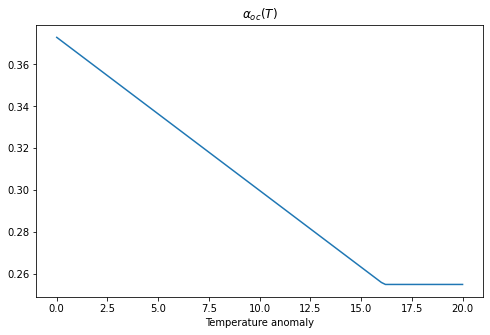

(0.255, 0.37295062500000004)

In [13]:
α_ocean = alphaocean(T_grid + To)
plt.plot(T_grid, α_ocean)
plt.xlabel("Temperature anomaly")
plt.title("$α_{oc}(T)$")
plt.show()
α_ocean.min(), α_ocean.max()

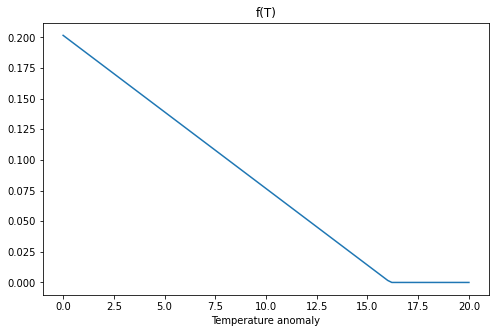

(0.0, 0.20162499999999994)

In [14]:
frac_sea_ice = fracseaice(T_grid + To)
plt.plot(T_grid, frac_sea_ice)
plt.xlabel("Temperature anomaly")
plt.title("f(T)")
plt.show()
frac_sea_ice.min(), frac_sea_ice.max()

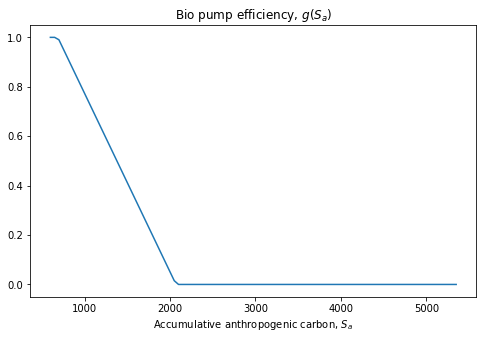

In [19]:
bio_pump_efficiency = biopump(F_grid - 580)
plt.plot(F_grid, bio_pump_efficiency)
plt.xlabel("Accumulative anthropogenic carbon, $S_a$")
plt.title("Bio pump efficiency, $g(S_a)$")
plt.show()

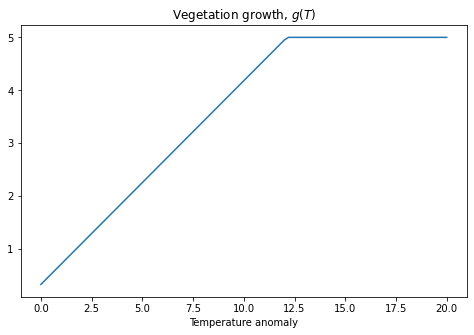

(0.334615384615385, 5.0)

In [16]:
vege_growth = veggrowth(To + T_grid)


plt.plot(T_grid, vege_growth)
plt.xlabel("Temperature anomaly")
plt.title("Vegetation growth, $g(T)$")
plt.show()

vege_growth.min(), vege_growth.max()

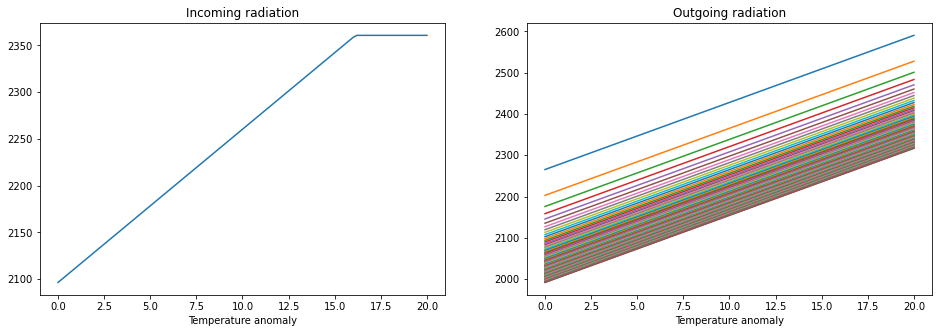

In [17]:
plt.subplots(1,2, figsize=(16, 5))
plt.subplot(121)

plt.title("Incoming radiation")
ri = Ri(To + T_grid)
ro = Ro(To + T_mat[:, 0, :], F_mat[:,0, :] - 580)
plt.plot(T_grid, ri)
plt.xlabel("Temperature anomaly")

plt.subplot(122)
plt.title("Outgoing radiation")
plt.plot(T_grid, ro)
plt.xlabel("Temperature anomaly")
plt.show()

Text(0.5, 0, 'Temperature anomaly')

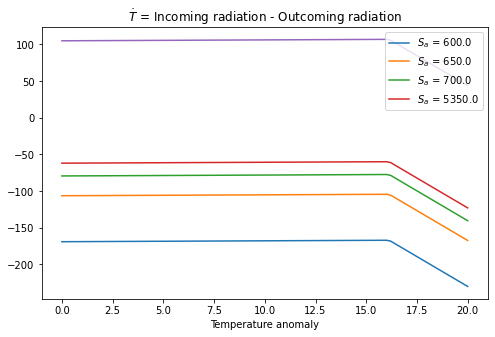

In [18]:
plt.title("$\\dot{T}$ = Incoming radiation - Outcoming radiation")
ri = Ri(To + T_mat[:, 0, :])
ro = Ro(To + T_mat[:, 0, :], F_mat[:,0, :] - 580)
plt.plot(T_grid, (ri - ro)[:, [0, 1,2,3, -1]])
plt.legend(["$S_a$ = {}".format(F) for F in F_grid[[0, 1, 2,-1]]])
plt.xlabel("Temperature anomaly")

In [20]:
T_grid[5], F_grid[17], C_grid[1]

(1.0, 1450.0, 542.5)

In [21]:
(ri - ro)[6, 17]

19.778118190112764

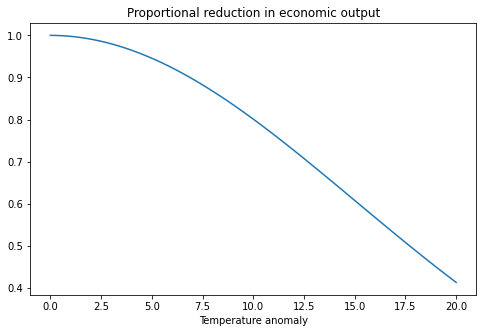

In [22]:
dG  = gamma_1 + gamma_2 * T_grid
G = gamma_1 * T_grid + gamma_2 / 2 * T_grid**2
plt.plot(T_grid, np.exp( -G) )
plt.xlabel("Temperature anomaly")
plt.title("Proportional reduction in economic output")
plt.show()

In [23]:
# Economic paramaters
gamma_1 = 1.7675 / 10000.
gamma_2 = 2 * 0.0022
delta   = 0.01
eta     = 0.032

# State variable
# Temperature anomaly, in celsius
T_min  = -10. 
T_max  = 20. # 
hT     = 1.5
T_grid = np.arange(T_min, T_max + hT, hT)

# atmospheric carbon concentration, in gigaton
C_min  = 532.5
C_max  = 1064
hC     = 40.
C_grid = np.arange(C_min, C_max + hC, hC)

# F, Sa in the notes, accumulative anthropogenic carbon, in gigaton
F_min = 600. # 10. avaoid 
F_max = 5325. # 2500 x2.13 gm # # on hold -> 4000 / 2.13 ppm
hF = 200.
F_grid = np.arange(F_min, F_max + hF, hF)

# meshgrid
(T_mat, C_mat, F_mat) = np.meshgrid(T_grid, C_grid, F_grid, indexing="ij")
stateSpace = np.hstack([
    T_mat.reshape(-1, 1, order="F"),
    C_mat.reshape(-1, 1, order="F"),
    F_mat.reshape(-1, 1, order="F")
])

T_mat.shape

(21, 15, 25)

In [24]:
v0 =  - eta * T_mat - eta * F_mat

dG  = gamma_1 + gamma_2 * T_mat *(T_mat >= 0)

epsilon  = 4.
count    = 0
error    = 1.
tol      = 1e-8
max_iter = 1000
fraction = 1


while error > tol and count < max_iter:
    
    dvdT  = finiteDiff(v0, 0, 1, hT)
    dvdTT = finiteDiff(v0, 0, 2, hT)
    dvdC  = finiteDiff(v0, 1, 1, hC)
#     dvdC[dvdC >= - 1e-16] = - 1e-16
    dvdCC = finiteDiff(v0, 1, 2, hC)
    dvdF  = finiteDiff(v0, 2, 1, hF)
    dvdFF = finiteDiff(v0, 2, 2, hF)

        

    Ca = - eta * delta / (dvdC + dvdF)
    Ca[Ca <= 1e-32] = 1e-32
    
    if count >=1:
        Ca = Ca * fraction + Ca_star * (1 - fraction)
       
    A  = - delta * np.ones(T_mat.shape)
    B1 = Ri(T_mat + To) - Ro(T_mat + To, C_mat)
    B2 = Volcan
    B2 += Ca * sa
    B2 -= wa * C_mat * vegcover * veggrowth(T_mat +To)
    B2 += oceanatmphysflux(T_mat + To) * (1 - fracseaice(T_mat + To))
    B2 += oceanbioflux(T_mat + To, F_mat - 580, sa) * (1 - fracseaice(T_mat + To))
    B2 += oceanatmcorrflux(C_mat) * (1 - fracseaice(T_mat + To))
    B3 = Ca
    C1 = 1e-4 * np.ones(T_mat.shape)
    C2 = 1e-4 * np.ones(T_mat.shape)
    C3 = np.zeros(T_mat.shape)
    D  = eta  * delta * np.log(Ca) + (eta - 1) * dG * B1

    out = PDESolver(stateSpace, A, B1, B2, B3, C1, C2, C3, D, v0, epsilon)
    v = out[2].reshape(v0.shape, order="F")

    rhs_error = A * v0 + B1 * dvdT + B2 * dvdC + B3 * dvdF + C1 * dvdTT + C2 * dvdCC + C3 * dvdFF + D
    rhs_error = np.max(abs(rhs_error))
    lhs_error = np.max(abs((v - v0)/epsilon))

    error = lhs_error
    v0 = v
    Ca_star = Ca
    count += 1

    print("Iteration %s: False Transient Error: %s; PDE Error %s" % (count, lhs_error, rhs_error))

print("Total iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

Iteration 1: False Transient Error: 1.9881922172310453; PDE Error 9.461871061628237
Iteration 2: False Transient Error: 1.6993324920677821; PDE Error 1.9881928540734828
Iteration 3: False Transient Error: 1.60225502045337; PDE Error 1.6997245349619376
Iteration 4: False Transient Error: 1.5129825269770265; PDE Error 1.6029120689314966
Iteration 5: False Transient Error: 1.4367392445833929; PDE Error 1.5129828452764964
Iteration 6: False Transient Error: 1.3750189022449533; PDE Error 1.436739534785741
Iteration 7: False Transient Error: 1.3205876871405309; PDE Error 1.3769689075427198
Iteration 8: False Transient Error: 1.269529113671144; PDE Error 1.3249204238034897
Iteration 9: False Transient Error: 1.2206280106127707; PDE Error 1.2742014865209272
Iteration 10: False Transient Error: 1.1736675350286276; PDE Error 1.225293559823208
Iteration 11: False Transient Error: 1.1285176791781169; PDE Error 1.1783128985294615
Iteration 12: False Transient Error: 1.0851099674372833; PDE Error 1.

Iteration 96: False Transient Error: 0.040591351855950863; PDE Error 0.1282910672189459
Iteration 97: False Transient Error: 0.0390487606276777; PDE Error 0.12846811048121287
Iteration 98: False Transient Error: 0.03756640353198615; PDE Error 0.12867008551804338
Iteration 99: False Transient Error: 0.03614216938354797; PDE Error 0.12919279908761894
Iteration 100: False Transient Error: 0.03477408657899128; PDE Error 0.1302938595326859
Iteration 101: False Transient Error: 0.0334608211615216; PDE Error 0.13171263860792193
Iteration 102: False Transient Error: 0.03221192533139583; PDE Error 0.1322739163879625
Iteration 103: False Transient Error: 0.03101296378781082; PDE Error 0.13210351045940838
Iteration 104: False Transient Error: 0.029807778380579797; PDE Error 0.13186241855934222
Iteration 105: False Transient Error: 0.028714836375286823; PDE Error 0.13173923686390854
Iteration 106: False Transient Error: 0.026824479967157866; PDE Error 0.13137488242363826
Iteration 107: False Trans

Iteration 188: False Transient Error: 0.013082523979549012; PDE Error 0.2233387713057331
Iteration 189: False Transient Error: 0.016654928073185832; PDE Error 0.4087794854252462
Iteration 190: False Transient Error: 0.015168161261274704; PDE Error 0.2247722127182883
Iteration 191: False Transient Error: 0.044472484821442365; PDE Error 1.1091133619189815
Iteration 192: False Transient Error: 0.043234560793315224; PDE Error 1.2411173040706969
Iteration 193: False Transient Error: 0.013291638341048552; PDE Error 0.1635226491792725
Iteration 194: False Transient Error: 0.020272117990585786; PDE Error 0.6705482984914447
Iteration 195: False Transient Error: 0.014397908271884622; PDE Error 0.22110603541428953
Iteration 196: False Transient Error: 0.13822096024244457; PDE Error 0.4700043823876701
Iteration 197: False Transient Error: 0.1372679099170244; PDE Error 5.970157839957462
Iteration 198: False Transient Error: 0.019101449405273155; PDE Error 0.9753696350988716
Iteration 199: False Tra

Iteration 281: False Transient Error: 0.012508968863104156; PDE Error 0.4870249419055832
Iteration 282: False Transient Error: 0.019568731099991105; PDE Error 0.1598663661201467
Iteration 283: False Transient Error: 0.022822753493885503; PDE Error 0.20353451213185292
Iteration 284: False Transient Error: 0.01910498506052772; PDE Error 0.2070215012927883
Iteration 285: False Transient Error: 0.015709406359201025; PDE Error 0.1624003666156857
Iteration 286: False Transient Error: 0.018078557567093964; PDE Error 0.16041828117815315
Iteration 287: False Transient Error: 0.02181588030634104; PDE Error 0.5066644632322088
Iteration 288: False Transient Error: 0.022722565192806396; PDE Error 0.7062660422999902
Iteration 289: False Transient Error: 0.014089473526388268; PDE Error 0.48356957776807663
Iteration 290: False Transient Error: 0.014942639810097136; PDE Error 0.18359824857429619
Iteration 291: False Transient Error: 0.07575555557300853; PDE Error 0.170164687758235
Iteration 292: False 

Iteration 373: False Transient Error: 1.270127978817751; PDE Error 0.19986526714016706
Iteration 374: False Transient Error: 1.163683012822032; PDE Error 47.54722289223093
Iteration 375: False Transient Error: 0.09286647156645797; PDE Error 1.1960506677407248
Iteration 376: False Transient Error: 0.018424087073284266; PDE Error 0.37653721216973673
Iteration 377: False Transient Error: 0.01747313047462213; PDE Error 0.515189159471585
Iteration 378: False Transient Error: 0.02024237818945593; PDE Error 0.22787990882315984
Iteration 379: False Transient Error: 0.016444663122340275; PDE Error 0.17626259080798223
Iteration 380: False Transient Error: 0.019279688003957532; PDE Error 0.16579167319993848
Iteration 381: False Transient Error: 0.019478046654790346; PDE Error 0.19466992336445132
Iteration 382: False Transient Error: 0.02097505653288015; PDE Error 0.7223334666860209
Iteration 383: False Transient Error: 0.015447107616921335; PDE Error 0.42400147283239864
Iteration 384: False Trans

Iteration 466: False Transient Error: 0.017473596628918703; PDE Error 0.27464776488783155
Iteration 467: False Transient Error: 0.015391761516834801; PDE Error 0.16337699803991512
Iteration 468: False Transient Error: 0.01830534334950225; PDE Error 0.16825062296188542
Iteration 469: False Transient Error: 0.015698457794556815; PDE Error 0.5109843288737862
Iteration 470: False Transient Error: 0.015255104094333477; PDE Error 0.16013512221379456
Iteration 471: False Transient Error: 0.015164672877791621; PDE Error 0.16031701139897825
Iteration 472: False Transient Error: 0.01861221578616036; PDE Error 0.16131826931947124
Iteration 473: False Transient Error: 0.017757891899766343; PDE Error 0.1684123175823249
Iteration 474: False Transient Error: 0.01662608256400667; PDE Error 0.182654820400862
Iteration 475: False Transient Error: 0.017867529432593253; PDE Error 0.15917844566445938
Iteration 476: False Transient Error: 0.017343661932212255; PDE Error 0.22349802878821112
Iteration 477: Fa

Iteration 559: False Transient Error: 0.021157184865309625; PDE Error 0.26197056459054546
Iteration 560: False Transient Error: 0.017555644762187975; PDE Error 0.1538882299244846
Iteration 561: False Transient Error: 0.024611360321929558; PDE Error 0.17915493223605683
Iteration 562: False Transient Error: 0.023830878398269806; PDE Error 0.9905073390683226
Iteration 563: False Transient Error: 0.02326197504880905; PDE Error 0.20603199254239613
Iteration 564: False Transient Error: 0.01811909749162445; PDE Error 0.15824300879452569
Iteration 565: False Transient Error: 0.02080386952347346; PDE Error 0.1575363481935912
Iteration 566: False Transient Error: 0.017897353985560218; PDE Error 0.17005424005720635
Iteration 567: False Transient Error: 0.01680501111182616; PDE Error 0.17479676687034607
Iteration 568: False Transient Error: 0.02199486830716109; PDE Error 0.5972940262811557
Iteration 569: False Transient Error: 0.01724771762741195; PDE Error 0.15920560688943075
Iteration 570: False

Iteration 651: False Transient Error: 0.025200457301194648; PDE Error 0.16971604484885505
Iteration 652: False Transient Error: 0.018692623200552275; PDE Error 0.16456664070210492
Iteration 653: False Transient Error: 0.015909600155006254; PDE Error 0.1618938947891384
Iteration 654: False Transient Error: 0.02395310204780387; PDE Error 0.1711756555044457
Iteration 655: False Transient Error: 0.016869406807696056; PDE Error 0.15381612001926648
Iteration 656: False Transient Error: 0.04958256353652496; PDE Error 0.16558075644884607
Iteration 657: False Transient Error: 0.025593446250187182; PDE Error 0.2996974509310964
Iteration 658: False Transient Error: 0.01691251928124357; PDE Error 0.15799924160638668
Iteration 659: False Transient Error: 0.02353498796271266; PDE Error 0.8042950540578155
Iteration 660: False Transient Error: 0.01904039567102176; PDE Error 0.9181413637354933
Iteration 661: False Transient Error: 0.018393947684962123; PDE Error 0.16842762192001004
Iteration 662: False

Iteration 744: False Transient Error: 0.016785088691889924; PDE Error 0.17702625343520406
Iteration 745: False Transient Error: 0.014227929684095864; PDE Error 0.17814606240804687
Iteration 746: False Transient Error: 0.01601200108741649; PDE Error 0.16003661613328068
Iteration 747: False Transient Error: 0.023599327720155702; PDE Error 0.4088086405658967
Iteration 748: False Transient Error: 0.021301682529970722; PDE Error 0.5014860679323329
Iteration 749: False Transient Error: 0.016731847649652604; PDE Error 0.16227412243855088
Iteration 750: False Transient Error: 0.02811893052577292; PDE Error 0.16145216463297807
Iteration 751: False Transient Error: 0.03436378887594789; PDE Error 1.4945953998848371
Iteration 752: False Transient Error: 0.01920472772142431; PDE Error 0.16548836225040997
Iteration 753: False Transient Error: 0.018245405809175975; PDE Error 0.16614071012507337
Iteration 754: False Transient Error: 0.016268311407112282; PDE Error 0.1495966339927235
Iteration 755: Fal

Iteration 837: False Transient Error: 0.01621641645942004; PDE Error 0.18119465026954917
Iteration 838: False Transient Error: 0.07815675954817754; PDE Error 0.15547985159934896
Iteration 839: False Transient Error: 0.06923350612173443; PDE Error 2.6945201760855184
Iteration 840: False Transient Error: 0.017123817672380262; PDE Error 0.3396983947477783
Iteration 841: False Transient Error: 0.018714548644225865; PDE Error 0.16183026305306272
Iteration 842: False Transient Error: 0.01942198293338189; PDE Error 0.17074679470632548
Iteration 843: False Transient Error: 0.01767656441277167; PDE Error 0.26208966696730585
Iteration 844: False Transient Error: 0.020948002229254907; PDE Error 0.16802198115413258
Iteration 845: False Transient Error: 0.03220557550069242; PDE Error 0.17947915038846807
Iteration 846: False Transient Error: 0.027381038579234962; PDE Error 0.25567600934150436
Iteration 847: False Transient Error: 0.019458040855965517; PDE Error 0.17467722400639252
Iteration 848: Fal

Iteration 930: False Transient Error: 0.015468569740488186; PDE Error 0.16040755345925461
Iteration 931: False Transient Error: 0.018306006921346207; PDE Error 0.32667236418546886
Iteration 932: False Transient Error: 0.3063174616180462; PDE Error 0.5518203582668999
Iteration 933: False Transient Error: 0.15016974093132796; PDE Error 0.3282785893786152
Iteration 934: False Transient Error: 0.08735111156752692; PDE Error 1.0095715702686503
Iteration 935: False Transient Error: 0.029665123129957956; PDE Error 0.16852215403722814
Iteration 936: False Transient Error: 0.02736626708109206; PDE Error 0.15851214582549744
Iteration 937: False Transient Error: 0.02097562286497142; PDE Error 0.16174207989686584
Iteration 938: False Transient Error: 0.045188732217502886; PDE Error 0.18568444954715124
Iteration 939: False Transient Error: 0.021893979133990545; PDE Error 0.1671727399697862
Iteration 940: False Transient Error: 0.02283481154083104; PDE Error 1.0114417825323745
Iteration 941: False T

In [25]:
B1.max(), B1.min(), v0.min(), v0.mean(), v0.max(), Ca.min(), Ca.max(), v0.mean()

(32.92500734401847,
 -65.86220037528938,
 -0.49262872371901034,
 0.01795550349984626,
 0.9330401339335717,
 1e-32,
 15330.547355914554,
 0.01795550349984626)

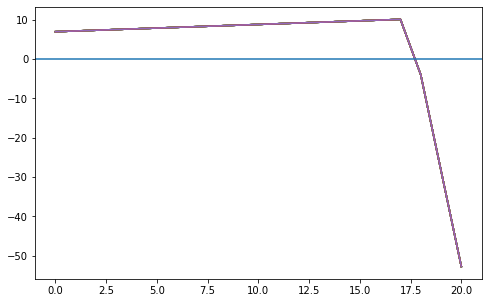

In [26]:
plt.plot(B1[:, 4, :])
plt.axhline(0)
plt.show()

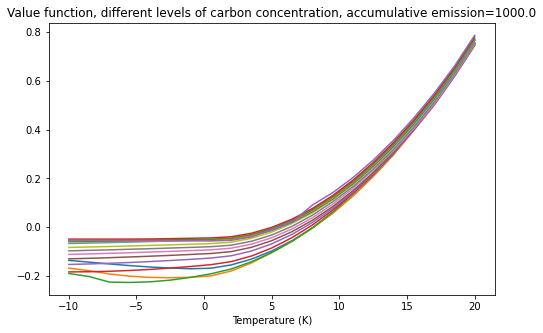

In [27]:
ii = 2
plt.plot(T_grid, v0[:, :, ii])
plt.xlabel("Temperature (K)")
plt.title("Value function, different levels of carbon concentration, accumulative emission={}".format(F_grid[ii]))
plt.show()

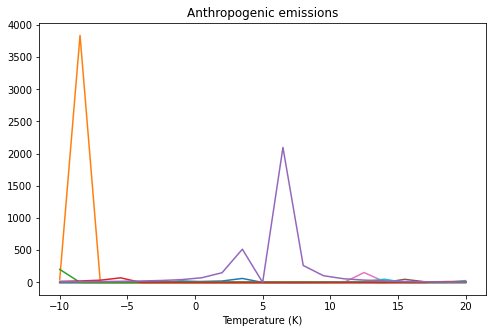

In [28]:
plt.plot(T_grid, Ca[:, :, ii])
plt.xlabel("Temperature (K)")
plt.title("Anthropogenic emissions")
plt.show()

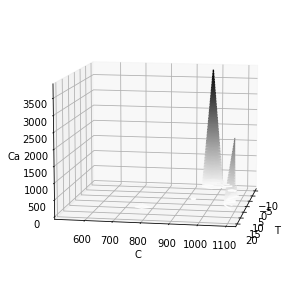

In [29]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(T_mat[:, :, 10], C_mat[:, :, 10], Ca[:, :, ii], 90, cmap='binary')
ax.set_xlabel('T')
ax.set_ylabel('C')
ax.set_zlabel('Ca')
ax.view_init(10, 10)

In [33]:
t_max = 100.
dt = 1/12
gridpoints = (T_grid, C_grid, F_grid)   
Ca_func = RegularGridInterpolator(gridpoints, Ca)

T_0 = 9.72 + 1.1
C_0 = 587.40
F_0 = 870

def get_e(x):
    return Ca_func([x[0] - To, x[1], x[2]])

# Ocean albedo
def alphaocean_1d(T):
    if T < Talphaocean_low:
        return alphaocean_max
    elif T < Talphaocean_high:
        return alphaocean_max + (alphaocean_min - alphaocean_max) / (Talphaocean_high - Talphaocean_low) * (T - Talphaocean_low)
    else: # so T is higher
        return alphaocean_min

# Vegetation growth function
def veggrowth_1d(T):
    if T < Tlow:
        return 0
    if (T >= Tlow) and (T < Topt1):
        return acc / (Topt1 - Tlow) * (T - Tlow)
    if (T >= Topt1) and (T <= Topt2):
        return acc
    if (T > Topt2) and (T < Thigh):
        #return acc
        return acc / (Topt2 - Thigh) * (T - Thigh)
    if T > Thigh:
        #return acc
        return 0

def oceanatmphysflux_1d(T):
    return 1 / tauc * (coc0 * (np.exp(-bP * (T - T0))))

def fracseaice_1d(T):
    if T < Talphaocean_low:
        return 1
    elif T < Talphaocean_high:
        return 1 - 1 / (Talphaocean_high - Talphaocean_low) * (T - Talphaocean_low)
    else: # so T is higher
        return 0

def biopump_1d(Cc):
    if Cc < Cbio_low:
        return 1
    elif Cc < Cbio_high:
        return 1 - 1 / (Cbio_high - Cbio_low) * (Cc - Cbio_low)
    else: 
        return 0


def oceanbioflux_1d(T, F, sa):
     return 1/tauc * (coc0 * (np.exp(bB * biopump_1d(F) * (T - T0))))

def oceanatmcorrflux_1d(C):
    return 1 / tauc * (- cod * C)


def mu_T(x):
    Ri_t = 1 / cearth * (Q0 * (1 - p * alphaland - (1 - p) * alphaocean(x[0])))
    Ro_t = 1 / cearth * (kappa * (x[0] - Tkappa) -  B * np.log(x[1] / C0))
    return Ri_t - Ro_t

def mu_C(x):
    Ca_t = Ca_func([x[0] - To, x[1], x[2]])
    dC = Volcan
    dC += Ca_t * sa
    dC -= wa * x[1] * vegcover * veggrowth_1d(x[0])
    dC += oceanatmphysflux_1d(x[0]) * (1 - fracseaice_1d(x[0]))
    dC += oceanbioflux_1d(x[0], x[2], sa) * (1 - fracseaice_1d(x[0]))
    dC += oceanatmcorrflux_1d(x[1]) * (1 - fracseaice_1d(x[0]))
    return dC

def mu_Sa(x):
    return Ca_func([x[0] - To, x[1], x[2]])

years  = np.arange(0, t_max + dt, dt)
pers   = len(years)

hist      = np.zeros([pers, 3])
e_hist    = np.zeros([pers])


for tm in range(pers):
    if tm == 0:
        # initial points
        hist[0,:] = [T_0, C_0, F_0] # logL
        e_hist[0] = get_e(hist[0, :])

    else:
        # other periods
        e_hist[tm] = get_e(hist[tm-1,:])

        hist[tm,0] = hist[tm-1,0] + mu_T(hist[tm-1,:]) * dt
        hist[tm,1] = hist[tm-1,1] + mu_C(hist[tm-1,:]) * dt
        hist[tm,2] = hist[tm-1,2] + mu_Sa(hist[tm-1,:]) * dt


Text(0.5, 1.0, '$S_a$')

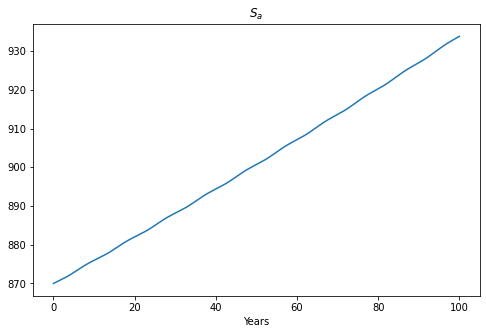

In [35]:
plt.plot(years, hist[:, 2])
plt.xlabel("Years")
plt.title("$S_a$")

Text(0.5, 1.0, 'Emission')

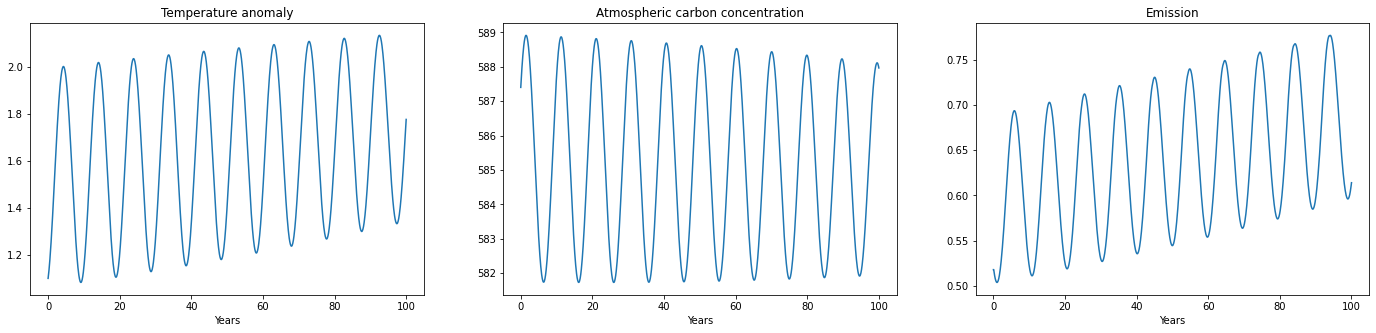

In [32]:
plt.subplots(1,3, figsize=(24,5))
plt.subplot(131)
plt.plot(years, hist[:, 0] - To)
plt.xlabel("Years")
plt.title("Temperature anomaly")
plt.subplot(132)
plt.plot(years, hist[:, 1])
plt.xlabel("Years")
plt.title("Atmospheric carbon concentration")
plt.subplot(133)
plt.plot(years, e_hist)
plt.xlabel("Years")
plt.title("Emission")